In [2]:
!pip install -q bertopic umap-learn hdbscan polars sentence-transformers tensorflow scikit-learn joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.8 MB/s eta 0:00:00


In [3]:
# --- Complete Code to Load ALL Saved Project Artifacts ---
import polars as pl
import numpy as np
import joblib
from google.colab import drive

# Configuration
DRIVE_PATH = '/content/drive/My Drive/DS_Project/'

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Loading Components
try:
    # A. Load Embeddings (The features for supervised modeling and BERTopic processing)
    emb_full = np.load(DRIVE_PATH + 'embeddings_full.npy')
    print(f"✅ Embeddings loaded successfully. Shape: {emb_full.shape}")

    # B. Load Analyzed Data (The full DataFrame with 'topic_id', 'primary_theme', 'sentiment')
    df_full_analyzed = pl.read_parquet(DRIVE_PATH + 'df_full_analyzed.parquet')
    print(f"✅ Analyzed DataFrame loaded. Rows: {df_full_analyzed.height}")

    # C. Load BERTopic Model (For final visualization/dissection logic)
    topic_model_full = joblib.load(DRIVE_PATH + 'topic_model_full.pkl')
    print("✅ BERTopic model loaded.")

    # D. Load Analytical Metrics (The table summarizing all 871 topics)
    topic_summary_metrics = pl.read_parquet(DRIVE_PATH + 'topic_summary_metrics_final.parquet')
    print("✅ Final Analytical Metrics table loaded.")

except FileNotFoundError as e:
    print("\nFATAL ERROR: Could not load essential project files.")
    print("Please ensure the DRIVE_PATH is correct and all files exist.")
    raise e

# --- Resume Point ---
print("\nProject environment fully loaded. You can now proceed directly to analysis and presentation code.")

Mounted at /content/drive
✅ Embeddings loaded successfully. Shape: (73834, 384)
✅ Analyzed DataFrame loaded. Rows: 73834


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


✅ BERTopic model loaded.
✅ Final Analytical Metrics table loaded.

Project environment fully loaded. You can now proceed directly to analysis and presentation code.


In [4]:
# ===============================
# 0. SETUP (imports + row_id)
# ===============================

import numpy as np
import pandas as pd
import polars as pl
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import os

if "row_id" not in df_full_analyzed.columns:
    df_full_analyzed = df_full_analyzed.with_row_count("row_id")

print("✅ Setup ready. Columns:", df_full_analyzed.columns)


✅ Setup ready. Columns: ['row_id', 'date', 'original_text', 'url', 'author_hash', 'language', 'primary_theme', 'english_keywords', 'sentiment', 'main_emotion', 'secondary_themes', 'topic_id']


/tmp/ipython-input-3738123323.py:16: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df_full_analyzed = df_full_analyzed.with_row_count("row_id")


In [5]:
# ==================================
# 1. TOPIC NAME FROM BERTopic MODEL
# ==================================

def get_topic_name_from_model(topic_id: int) -> str:
    """
    Get topic name/label from BERTopic's get_topic_info().
    Falls back to 'Topic_{id}' if not found.
    """
    info_df = topic_model_full.get_topic_info()  # pandas DataFrame
    row = info_df[info_df["Topic"] == topic_id]
    if row.empty:
        return f"Topic_{topic_id}"
    return str(row["Name"].iloc[0])


In [6]:
# ==================================
# 2. CORE: COMPUTE SIDES FOR A TOPIC
# ==================================

def compute_topic_sides(topic_id: int,
                        df_full_pl: pl.DataFrame,
                        emb_full: np.ndarray,
                        n_clusters: int = 3,
                        max_docs_per_topic: int = 500) -> pd.DataFrame:
    """
    For a given topic_id:
      - sample posts from df_full_pl
      - cluster into n_clusters using emb_full
      - extract distinctive TF-IDF terms per cluster
      - compute percentage + sentiment + readable side_text

    Returns: pandas DataFrame with:
      topic_id, topic_name, cluster, n_posts, percentage,
      avg_sentiment, top_terms, side_text
    """

    # 1) Filter rows for this topic
    df_topic_pl = df_full_pl.filter(pl.col("topic_id") == topic_id)
    if df_topic_pl.height == 0:
        raise ValueError(f"No rows found for topic_id={topic_id}")

    # 2) Downsample for speed
    if df_topic_pl.height > max_docs_per_topic:
        df_topic_pl = df_topic_pl.sample(n=max_docs_per_topic, with_replacement=False)

    # 3) Convert to pandas and align embeddings using row_id
    df_topic = df_topic_pl.to_pandas()
    if "row_id" not in df_topic.columns:
        raise ValueError("row_id missing – ensure with_row_count('row_id') was called on df_full_analyzed.")

    row_ids = df_topic["row_id"].values
    emb_mat = emb_full[row_ids]
    n_docs = df_topic.shape[0]

    # Keep only needed columns
    keep_cols = [c for c in ["row_id", "original_text", "topic_id", "sentiment"] if c in df_topic.columns]
    df_topic = df_topic[keep_cols]

    # 4) PCA + KMeans stance clustering
    n_components = min(20, emb_mat.shape[1])
    pca = PCA(n_components=n_components, random_state=42)
    emb_reduced = pca.fit_transform(emb_mat)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
    df_topic["stance_cluster"] = kmeans.fit_predict(emb_reduced)

    # 5) TF-IDF over this topic's texts
    vectorizer = TfidfVectorizer(stop_words="english", max_features=5000, min_df=2)
    X = vectorizer.fit_transform(df_topic["original_text"].fillna(""))
    terms = np.array(vectorizer.get_feature_names_out())
    mean_tfidf_global = X.mean(axis=0).A1

    # 6) Compute per-side stats and descriptions
    rows = []
    for c in range(n_clusters):
        mask = (df_topic["stance_cluster"] == c)
        if not mask.any():
            continue

        idx = np.where(mask.values)[0]
        X_c = X[idx]
        mean_tfidf_c = X_c.mean(axis=0).A1

        scores = mean_tfidf_c - mean_tfidf_global
        top_idx = np.argsort(scores)[::-1][:15]
        top_terms = terms[top_idx]

        n_posts = int(mask.sum())
        pct = 100.0 * n_posts / n_docs

        if "sentiment" in df_topic.columns:
            avg_sent = df_topic.loc[mask, "sentiment"].mean()
        else:
            avg_sent = np.nan

        # sentiment bucket
        if np.isnan(avg_sent):
            sent_label = "unknown sentiment"
        elif avg_sent <= -0.4:
            sent_label = "very negative"
        elif avg_sent <= -0.1:
            sent_label = "negative"
        elif abs(avg_sent) < 0.1:
            sent_label = "neutral"
        else:
            sent_label = "positive"

        # basic cleaning of terms (optional profanity removal)
        key_terms = [t for t in top_terms if t not in {"fuck"}][:5]
        key_str = ", ".join(key_terms)

        side_text = (
            f"{pct:.1f}% of posts form a side that mainly talks about "
            f"{key_str}, with an overall {sent_label} tone "
            f"(avg_sentiment={avg_sent:.3f})."
        )

        rows.append({
            "topic_id": topic_id,
            "cluster": c,
            "n_posts": n_posts,
            "percentage": pct,
            "avg_sentiment": avg_sent,
            "top_terms": ", ".join(top_terms),
            "side_text": side_text,
        })

    df_sides = pd.DataFrame(rows).sort_values("percentage", ascending=False).reset_index(drop=True)

    # Attach topic name
    topic_name = get_topic_name_from_model(topic_id)
    df_sides["topic_name"] = topic_name

    return df_sides


In [7]:
# ===========================
# 3. SAVE / LOAD
# ===========================

def save_topic_sides(df_sides: pd.DataFrame,
                     topic_id: int,
                     drive_path: str = DRIVE_PATH) -> str:
    """
    Save topic sides to Parquet under:
      {drive_path}/topic_sides/topic_{topic_id}_sides.parquet
    """
    out_dir = os.path.join(drive_path, "topic_sides")
    os.makedirs(out_dir, exist_ok=True)

    out_path = os.path.join(out_dir, f"topic_{topic_id}_sides.parquet")
    pl.from_pandas(df_sides).write_parquet(out_path)
    return out_path


def load_topic_sides(topic_id: int,
                     drive_path: str = DRIVE_PATH) -> pd.DataFrame:
    """
    Load previously saved sides for a topic.
    """
    path = os.path.join(drive_path, "topic_sides", f"topic_{topic_id}_sides.parquet")
    df_pl = pl.read_parquet(path)
    return df_pl.to_pandas()


In [8]:
# ===========================
# 4. TEXT OUTPUT
# ===========================

def print_topic_sides(df_sides: pd.DataFrame, topic_id: int):
    """
    Pretty-print side descriptions for a topic.
    """
    topic_name = df_sides["topic_name"].iloc[0] if "topic_name" in df_sides.columns else get_topic_name_from_model(topic_id)
    header = f"=== Topic {topic_id}: {topic_name} — Sides of the Conversation ==="
    print(f"\n{header}\n")
    for _, row in df_sides.iterrows():
        print(row["side_text"])
    print()


In [18]:
# ===========================
# 5. VISUALIZATIONS
# ===========================

def plot_topic_sides(df_sides: pd.DataFrame, topic_id: int):
    topic_name = df_sides["topic_name"].iloc[0] if "topic_name" in df_sides.columns else f"Topic_{topic_id}"

    clusters = df_sides["cluster"].astype(str).tolist()
    percentages = df_sides["percentage"].tolist()
    sentiments = df_sides["avg_sentiment"].tolist()

    x = np.arange(len(clusters))

    cmap = plt.cm.RdYlGn
    sent_min, sent_max = -0.5, 0.5
    sent_norm = [(s - sent_min) / (sent_max - sent_min) for s in sentiments]
    colors = [cmap(v) for v in sent_norm]

    fig, ax = plt.subplots(figsize=(9, 5))
    bars = ax.bar(x, percentages, color=colors, edgecolor="black")

    max_pct = max(percentages)
    ax.set_ylim(0, max_pct * 1.15)

    ax.set_xticks(x)
    ax.set_xticklabels([f"Side {c}" for c in clusters])
    ax.set_ylabel("Percentage of posts (%)")
    ax.set_title(f"Sides of the Conversation – Topic {topic_id}: {topic_name}")

    for bar, pct in zip(bars, percentages):
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() * 0.90,
            f"{pct:.1f}%",
            ha="center",
            va="center",
            fontsize=10,
            color="black"
        )

    sm = plt.cm.ScalarMappable(
        cmap=cmap,
        norm=plt.Normalize(vmin=sent_min, vmax=sent_max)
    )
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Avg Sentiment (Red = Negative, Green = Positive)")

    plt.tight_layout()
    plt.show()


✅ Saved topic 11 sides to: /content/drive/My Drive/DS_Project/topic_sides/topic_11_sides.parquet

=== Topic 11: 11_damage_melee_level_camilla — Sides of the Conversation ===

44.3% of posts form a side that mainly talks about damage, aura, shadow, tank, power, with an overall neutral tone (avg_sentiment=0.038).
30.6% of posts form a side that mainly talks about team, legends, like, really, game, with an overall neutral tone (avg_sentiment=0.036).
25.1% of posts form a side that mainly talks about counter, combat, goes, opponent, fight, with an overall negative tone (avg_sentiment=-0.103).



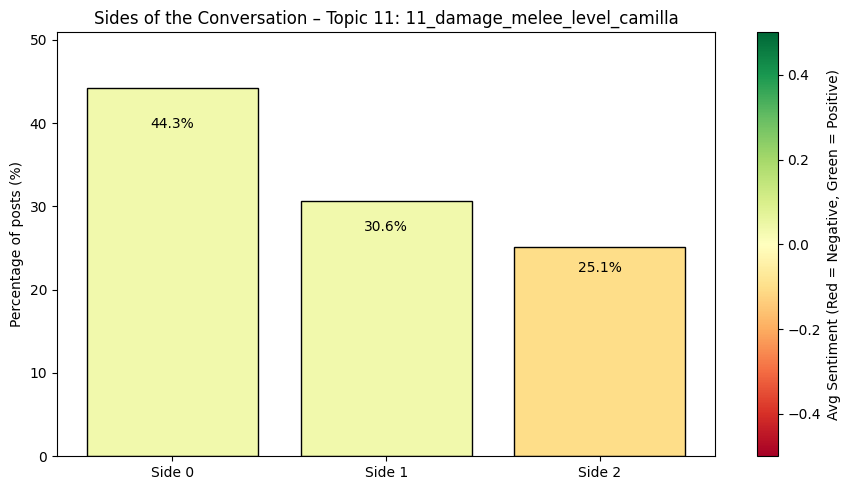

In [28]:
# ===========================
# 6. EXAMPLE USAGE
# ===========================

# Pick any topic id from BERTopic model (e.g., 1, 2, 6, etc.)
TARGET_TOPIC = 11

df_sides = compute_topic_sides(
    topic_id=TARGET_TOPIC,
    df_full_pl=df_full_analyzed,
    emb_full=emb_full,
    n_clusters=3,
    max_docs_per_topic=500
)

out_path = save_topic_sides(df_sides, TARGET_TOPIC, DRIVE_PATH)
print(f"✅ Saved topic {TARGET_TOPIC} sides to: {out_path}")

# Text summary
print_topic_sides(df_sides, TARGET_TOPIC)

# Visuals
plot_topic_sides(df_sides, TARGET_TOPIC)